In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error


In [2]:
print(np.__version__)

1.19.1


In [3]:
import pytorch_lightning as pl

C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

In [4]:
df = pd.read_excel('data.xlsx', skiprows=2)

In [5]:
df.head(10).style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#008080'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana'),
            ('color', 'black')]},

 {'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#DCDCDC')]}, 
 
 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 
  {'selector': 'tr:hover',
  'props': [('background', 'yellow')]},
]).hide_index()

data obrotu,data dostawy,godzina dostawy,kurs fixingu I (PLN/MWh),wolumen fixingu I (MWh),kurs fixingu II (PLN/MWh),wolumen fixingu II (MWh),kurs notowan ciaglych (PLN/MWh),wolumen notowan ciaglych (MWh)
2019-02-01 00:00:00,2019-02-02 00:00:00,1,208.830000,2006.800000,212.320000,1066.200000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,2,201.000000,2270.500000,204.090000,1155.600000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,3,195.000000,2644.800000,191.370000,1256.000000,195.00,10.00
2019-02-01 00:00:00,2019-02-02 00:00:00,4,189.000000,2355.700000,188.380000,1192.700000,190.25,20.00
2019-02-01 00:00:00,2019-02-02 00:00:00,5,189.260000,2324.500000,189.680000,1260.800000,190.25,20.00
2019-02-01 00:00:00,2019-02-02 00:00:00,6,191.210000,2364.900000,190.340000,1233.500000,191.50,10.00
2019-02-01 00:00:00,2019-02-02 00:00:00,7,203.000000,2264.200000,205.730000,1095.300000,203.00,10.00
2019-02-01 00:00:00,2019-02-02 00:00:00,8,213.810000,2199.400000,212.720000,1139.400000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,9,229.000000,2279.300000,220.410000,625.900000,-,-
2019-02-01 00:00:00,2019-02-02 00:00:00,10,242.760000,2721.300000,228.160000,934.500000,-,-


In [6]:
df.shape

(9504, 9)

In [7]:
df['year'] = pd.DatetimeIndex(df['data obrotu']).year
df['month'] = pd.DatetimeIndex(df['data obrotu']).month
df['day'] = pd.DatetimeIndex(df['data obrotu']).day

In [8]:
df_ = pd.DataFrame({'year': df['year'],
                     'month': df['month'],
                     'day': df['day']})

In [9]:
df['godzina dostawy'] = pd.to_numeric(df['godzina dostawy'], errors='coerce')

In [10]:
df['godzina dostawy'].isnull().sum()

1

In [11]:
df = df.dropna()

In [12]:
df['date'] = pd.to_datetime(df_) + pd.to_timedelta(df['godzina dostawy'], unit='h')

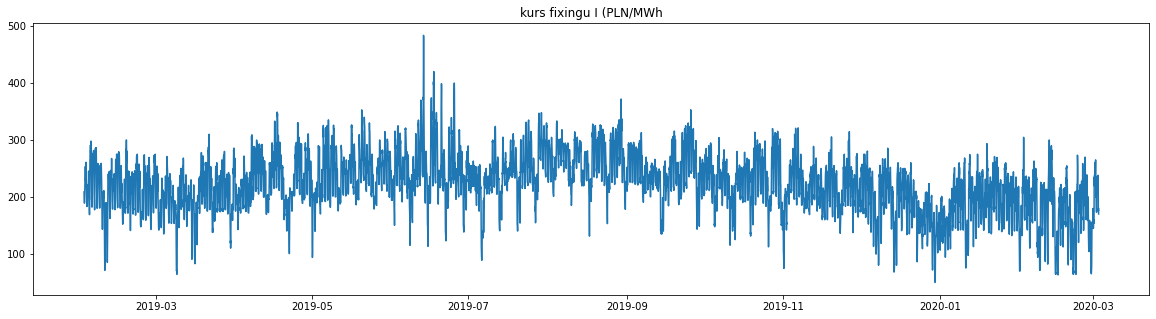

In [13]:
plt.figure(figsize=(20,5))
plt.plot(df['date'], df['kurs fixingu I (PLN/MWh)'])
plt.title("kurs fixingu I (PLN/MWh")
params = {"ytick.color" : "w",
          "xtick.color" : "white",
          "axes.labelcolor" : "white",
          "axes.edgecolor" : "white"
        }
plt.rcParams.update(params)
plt.show()

In [14]:
df = pd.DataFrame(data={'Date': df['date'], 'Kurs fixing':df['kurs fixingu I (PLN/MWh)']})

In [15]:
price = df[['Kurs fixing']]
scaler = MinMaxScaler(feature_range=(-1, 1))
# price['Kurs fixing'] = scaler.fit_transform(price['Kurs fixing'].values.reshape(-1,1))
price['Kurs fixing'] = scaler.fit_transform(price['Kurs fixing'].values.reshape(-1,1))

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
price

,Kurs fixing
0,-0.266914
1,-0.302988
2,-0.330630
3,-0.358273
4,-0.357075
...,...
9499,-0.169381
9500,-0.307595
9501,-0.422773
9502,-0.399737


In [17]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    print(data_raw)
    print(len(data_raw))
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [18]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

[[-0.26691392]
 [-0.30298772]
 [-0.33063049]
 ...
 [-0.42277303]
 [-0.39973739]
 [-0.44580867]]
9503


In [19]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [20]:
#Hyper-parametres
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [22]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.051810406148433685
Epoch  1 MSE:  0.05302644148468971
Epoch  2 MSE:  0.045810308307409286
Epoch  3 MSE:  0.04305553808808327
Epoch  4 MSE:  0.04370775446295738
Epoch  5 MSE:  0.04336974769830704
Epoch  6 MSE:  0.04120054468512535
Epoch  7 MSE:  0.038454312831163406
Epoch  8 MSE:  0.03637963905930519
Epoch  9 MSE:  0.03508685156702995
Epoch  10 MSE:  0.0322476290166378
Epoch  11 MSE:  0.027035852894186974
Epoch  12 MSE:  0.02470296248793602
Epoch  13 MSE:  0.02547404170036316
Epoch  14 MSE:  0.025275202468037605
Epoch  15 MSE:  0.021921247243881226
Epoch  16 MSE:  0.019465371966362
Epoch  17 MSE:  0.018794802948832512
Epoch  18 MSE:  0.018063709139823914
Epoch  19 MSE:  0.017147338017821312
Epoch  20 MSE:  0.016224421560764313
Epoch  21 MSE:  0.01506166160106659
Epoch  22 MSE:  0.013466262258589268
Epoch  23 MSE:  0.01196959987282753
Epoch  24 MSE:  0.011130180209875107
Epoch  25 MSE:  0.01040826179087162
Epoch  26 MSE:  0.009712999686598778
Epoch  27 MSE:  0.0090567534

In [24]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

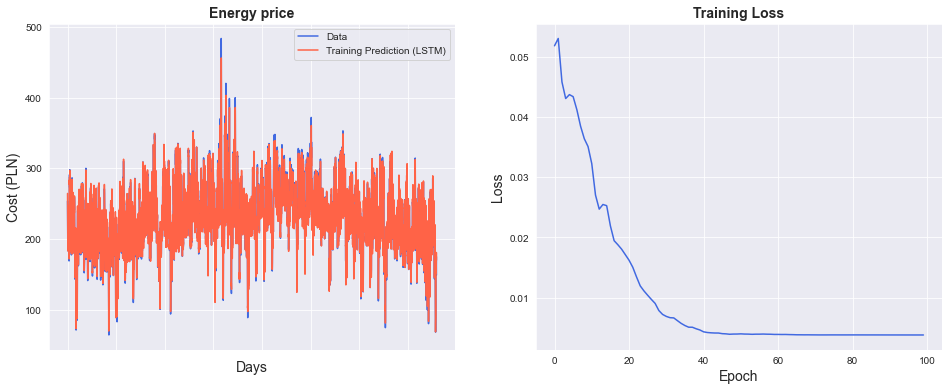

In [25]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Energy price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (PLN)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [26]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 13.41 RMSE
Test Score: 16.44 RMSE


In [27]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Kurs fixing'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [29]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (PLN)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()